In [34]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation, SegformerConfig, AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")
backbone = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized: ['segformer.encoder.test.bias', 'segformer.encoder.test.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
import torch
backbone.decode_head.classifier = torch.nn.Identity()

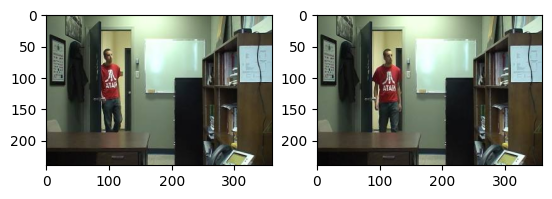

In [236]:
import os
import pylab
frames = os.listdir("/mnt/fastdata/dataset/baseline/office/input")
frames.sort()
pylab.subplot(1, 2, 1)
pylab.imshow(pylab.imread("/mnt/fastdata/dataset/baseline/office/input/"+frames[600]))
pylab.subplot(1, 2, 2)
pylab.imshow(pylab.imread("/mnt/fastdata/dataset/baseline/office/input/"+frames[610]))

In [196]:
from PIL import Image
image1 = image_processor(Image.open("/mnt/fastdata/dataset/baseline/office/input/"+frames[600]), return_tensors="pt")
image2 = image_processor(Image.open("/mnt/fastdata/dataset/baseline/office/input/"+frames[610]), return_tensors="pt")
image1_feature = backbone(**image1).logits 
image2_feature = backbone(**image2).logits

In [197]:
image1_feature = image1_feature.permute(0, 2, 3, 1).flatten(1, 2)[0]
image2_feature = image2_feature.permute(0, 2, 3, 1).flatten(1, 2)[0]

In [198]:
grid = torch.stack(torch.meshgrid(torch.arange(128), torch.arange(128)), dim=-1).float()

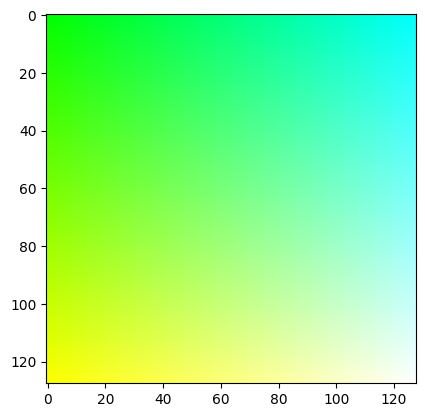

In [199]:
pylab.imshow(grid_.detach()/128)

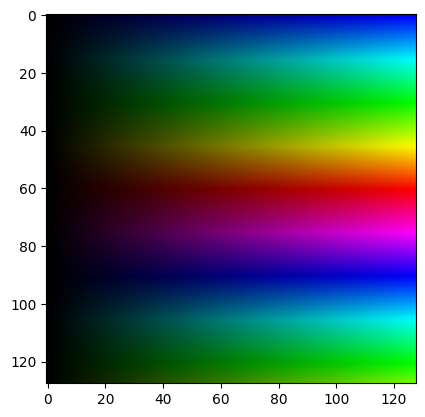

In [200]:
import cv2
# hsv to rgb (grid)
grid_ = torch.stack([grid[:,:,0], torch.ones(128, 128)*128, grid[:,:,1]], -1) 
pylab.imshow(cv2.cvtColor((grid_.numpy()/128 * 255).astype(np.uint8), cv2.COLOR_HSV2BGR)) 

In [215]:
import numpy as np
matching = (image1_feature @ image2_feature.T)/np.sqrt(768)
flow = (matching.softmax(0)[:,:,None] * grid_ - grid_).detach()/128
pylab.imshow(cv2.cvtColor((flow.numpy() * 255).astype(np.uint8), cv2.COLOR_HSV2BGR)) 

RuntimeError: The size of tensor a (16384) must match the size of tensor b (128) at non-singleton dimension 1

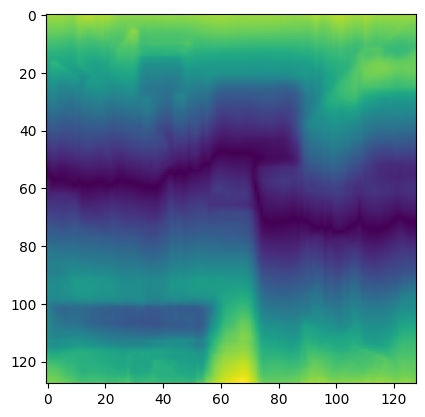

In [ ]:
flow = torch.abs((matching.softmax(-1) @ grid_.flatten(0, 1)) - grid_.flatten(0, 1)).reshape(128,128,3).detach()/128
# pylab.imshow(cv2.cvtColor((flow.numpy() * 255).astype(np.uint8), cv2.COLOR_HSV2BGR)) 
pylab.imshow(flow[:,:,0].detach().numpy()) 